In [87]:
%load_ext autoreload
%autoreload 2

import os
import subprocess
import sys
import warnings

warnings.simplefilter("ignore", FutureWarning)

%aimport xclone_config
project_config = xclone_config
os.chdir(project_config.ROOT)

from collections import Counter, defaultdict, OrderedDict
import itertools
from itertools import product as cartesian
import multiprocessing as mp
import pickle

import numba
from joblib import Parallel, delayed
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as sps
from tqdm import tqdm, tqdm_notebook

import matplotlib.pyplot as plt
import seaborn as sns

import toolkit
import util
from workspace.workspace_manager import WorkspaceManager

sns.set()

workspace = {}
for modality in ["scDNA", "scRNA"]:
    workspace.update({ 
        modality : WorkspaceManager(
            task_name="classification",
            experiment_info={
                "sample" : "STP_G&T",
                "modality" : modality
            },
            verbose=True
        )
    })
    workspace[modality].load_workspace()
    
assert workspace["scDNA"].experiment_info["sample"]\
        == workspace["scRNA"].experiment_info["sample"],\
    "scDNA and scRNA workspaces store different samples"

sample_tag = workspace["scDNA"].experiment_info["sample"]
print(f"Currently working on {sample_tag}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Currently working on STP_G&T


In [88]:
data = {}
for modality in ["scDNA", "scRNA"]:
    data[modality] = {
        data_name :
        util.pickle_load(data_dump)
        for data_name, data_dump in tqdm_notebook(
            workspace[modality].tmp_data.items(),
            f"{modality}, loading datasets into RAM"
        )
    }  

In [89]:
for modality in ["scDNA", "scRNA"]:
    count_matrix = toolkit.extract_counts(
        data[modality]["block_counts"]
    )
    is_all_missing = np.all(
        np.isnan(count_matrix) | (count_matrix == 0), 
        axis=1
    )
    data[modality]["block_counts"] =\
        data[modality]["block_counts"][~is_all_missing] 
    data[modality]["block_counts"].reset_index(drop=True, inplace=True)

In [90]:
common_blocks = (set(data["scDNA"]["block_counts"].BLOCK_ID) 
                & set(data["scRNA"]["block_counts"].BLOCK_ID))

print("Datasets have {} blocks in common".format(len(common_blocks)))

for modality in workspace.keys():
    data[modality]["block_counts"] = util.filter_by_isin(
        data[modality]["block_counts"], 
        "BLOCK_ID", 
        common_blocks
    ).reset_index(drop=True)

common_block_ids = data["scDNA"]["block_counts"]["BLOCK_ID"].values.astype(int)
    
assert (data["scDNA"]["block_counts"].shape[0] 
        == data["scRNA"]["block_counts"].shape[0])

Datasets have 10708 blocks in common


In [91]:
barcodes_with_labels = data["scDNA"]["clustering"]["BARCODE"]
for modality in ["scDNA", "scRNA"]:
    data[modality]["block_counts"] = toolkit.filter_barcodes(
        data[modality]["block_counts"],
        barcodes_with_labels
    )

In [92]:
# rodata_dir = "/icgc/dkfzlsdf/analysis/B260/users/v390v/xclone/"\
#              f"data/raw/{sample_tag}/scDNA"
# CNV_prime_parts = [
#     pd.read_csv(
#         f"{rodata_dir}/TabHaplotypeblock_with_phasedSNPs_1.bed", 
#         usecols=[0, 1, 2],
#         names=["CHROM", "START", "END"],
#         sep='\t'
#     ).drop_duplicates().reset_index(drop=True)
# ]
# for i in tqdm_notebook(range(9), "reading CNV information"):
#     snp_cnv = pd.read_csv(
#         f"{rodata_dir}/TabHaplotypeblock_with_phasedSNPs_{i + 1}.bed", 
#         usecols=[0, 1, 2, 3],
#         names=["CHROM", "START", "END", "CNV"],
#         sep='\t'
#     )
#     snp_cnv.drop_duplicates(inplace=True)
#     snp_cnv.reset_index(inplace=True, drop=True)
#     print(snp_cnv.shape, np.bincount(snp_cnv["CNV"]).argmax())
#     CNV_prime_parts.append(snp_cnv["CNV"].rename(columns={"CNV" : f"{i + 1}"}))
# CNV_prime_df = pd.concat(CNV_prime_parts, axis=1).rename(
#     columns={i : f"{i+1}" for i in range(9)}
# )
# CNV_prime_df = data["scDNA"]["block_counts"][["BLOCK_ID", "CHROM", "START", "END"]].merge(
#     CNV_prime_df, on=["CHROM", "START", "END"]
# )

# CNV_prime = CNV_prime_df.drop(
#     columns=["BLOCK_ID", "CHROM", "START", "END"]
# ).values.astype(float)
# is_all_missing = np.all(
#     np.isnan(CNV_prime) | (CNV_prime == 0),
#     axis=1
# )
# CNV_prime = CNV_prime[~is_all_missing]
# CNV_prime_df = CNV_prime_df[~is_all_missing]
# CNV_prime_df.reset_index(drop=True, inplace=True)
# util.pickle_dump(
#     CNV_prime_df, 
#     "/icgc/dkfzlsdf/analysis/B260/users/v390v/xclone/"
#     f"data/processed/{sample_tag}/scDNA/CNV_prime_df.pkl"
# )
# util.pickle_dump(
#     CNV_prime, 
#     "/icgc/dkfzlsdf/analysis/B260/users/v390v/xclone/"
#     f"data/processed/{sample_tag}/scDNA/CNV_prime.pkl"
# )

CNV_DNA_df = util.pickle_load(
    "/icgc/dkfzlsdf/analysis/B260/users/v390v/xclone/"
    f"data/processed/{sample_tag}/scDNA/CNV_DNA_df.pkl"
)
CNV_DNA = util.pickle_load(
    "/icgc/dkfzlsdf/analysis/B260/users/v390v/xclone/"
    f"data/processed/{sample_tag}/scDNA/CNV_DNA.pkl"
)
T = util.pickle_load(
    "/icgc/dkfzlsdf/analysis/B260/users/v390v/xclone/"
    f"data/processed/{sample_tag}/scDNA/T.pkl"
)

In [93]:
for modality in ["scDNA", "scRNA"]:
    data[modality]["block_counts"] = data[modality]["block_counts"].merge(
        CNV_DNA_df[["CHROM", "START", "END"]], 
        on=["CHROM", "START", "END"]
    )

In [94]:
D_DNA = toolkit.extract_counts(data["scDNA"]["block_counts"]).values
D_RNA = toolkit.extract_counts(
    data["scRNA"]["block_counts"],
#     toolkit.aggregate_by_barcode_groups(
#         data["scRNA"]["block_counts"],
#         data["scRNA"]["clustering"]
#     )
).values

A_DNA = toolkit.extract_counts(
    data["scDNA"]["block_counts"], 
    suffix="ad"
).values
A_RNA = toolkit.extract_counts(
    data["scRNA"]["block_counts"],
#     toolkit.aggregate_by_barcode_groups(
#         data["scRNA"]["block_counts"], 
#         data["scRNA"]["clustering"]
#     ),
    suffix="ad"
).values

In [95]:
data["scDNA"]["clustering"] = data["scDNA"]["clustering"][
    np.isin(data["scDNA"]["clustering"]["BARCODE"], 
            toolkit.extract_barcodes(data["scDNA"]["block_counts"]))
].reset_index(drop=True)

In [96]:
T_max = 5
I_DNA = data["scDNA"]["clustering"]["LABEL"].astype(int).values - 1

In [97]:
print(f"RAW, ({I_DNA.size} cells)")
display(pd.DataFrame(
    np.column_stack((
        np.arange(CNV_DNA.shape[1]), 
        np.round(100 * np.mean(np.isnan(CNV_DNA), axis=0))
    )), columns=["cluster", "% of NaNs"]
))

cells_to_keep = (I_DNA != 6)
clusters_to_keep = [0, 1, 2, 3, 4, 5, 7, 8]

D_DNA = D_DNA[:, cells_to_keep]
D_RNA = D_RNA[:, cells_to_keep]

A_DNA = A_DNA[:, cells_to_keep]
A_RNA = A_RNA[:, cells_to_keep]

I_DNA = I_DNA[cells_to_keep]
I_DNA[I_DNA > 6] = I_DNA[I_DNA > 6] - 1

CNV_DNA = CNV_DNA[:, clusters_to_keep]
T = T[:, clusters_to_keep]

print(f"W/O cluster 6 of dead cells ({I_DNA.size} cells remain)")
display(pd.DataFrame(
    np.column_stack((
        np.arange(CNV_DNA.shape[1]), 
        np.round(100 * np.mean(np.isnan(CNV_DNA), axis=0))
    )), columns=["cluster", "% of NaNs"]
))

print(f"RAW: ({D_DNA.shape[0]} blocks in each cell)")

idx = np.all(T > 0, axis=1) * np.all(~np.isnan(T), axis=1)

CNV_DNA = CNV_DNA[idx, :]
T = T[idx, :]
D_RNA = np.nan_to_num(D_RNA[idx, :])
D_DNA = np.nan_to_num(D_DNA[idx, :])

A_RNA = np.nan_to_num(A_RNA[idx, :])
A_DNA = np.nan_to_num(A_DNA[idx, :])

print(f"ONLY NON-MISSING: ({D_DNA.shape[0]} blocks in each cell)")

RAW, (89 cells)


,cluster,% of NaNs
0,0.0,0.0
1,1.0,0.0
2,2.0,0.0
3,3.0,6.0
4,4.0,0.0
5,5.0,0.0
6,6.0,53.0
7,7.0,0.0
8,8.0,0.0


W/O cluster 6 of dead cells (80 cells remain)


,cluster,% of NaNs
0,0.0,0.0
1,1.0,0.0
2,2.0,0.0
3,3.0,6.0
4,4.0,0.0
5,5.0,0.0
6,6.0,0.0
7,7.0,0.0


RAW: (10152 blocks in each cell)
ONLY NON-MISSING: (5912 blocks in each cell)


/icgc/dkfzlsdf/analysis/B260/users/v390v/.conda/envs/xclone/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in greater


In [98]:
for modality in ["scDNA", "scRNA"]:
    for count_type in ["AD", "DP"]:
        count_matrix = toolkit.extract_counts(
            data[modality]["block_counts"],
            suffix=count_type.lower()
        ).values
        sparse_count_matrix = sp.sparse.coo_matrix(count_matrix)
        sp.sparse.save_npz(
            matrix=sparse_count_matrix,
            file=f"{workspace[modality].dir}/block_{count_type}.npz"
        )

In [99]:
def classification_report(labels, title, outfile=None, show=True):
                
        sns.set(style="whitegrid", font_scale=1.5);
        fig, ax = plt.subplots(2, 1, figsize=(20,30))
        ax[0].set_title("Cluster label assigned by XClone", fontsize=20)
        
        palette =  {
            1 : "xkcd:orange",
            2 : "xkcd:azure",
            3 : "xkcd:cyan",
            4 : "xkcd:yellow",
            5 : "xkcd:blue",
            6 : "xkcd:red",
            7 : "xkcd:pink",
            8 : "xkcd:grey",
            9 : "xkcd:black"
        }
        
        sns.countplot(
            labels, 
            palette=palette,
            ax=ax[0]
        )

        ax[1].set_title(title)
        
        sns.scatterplot(
            x="TSNE_1", y="TSNE_2", 
            hue=labels, 
            data=data["scRNA"]["clustering"], 
            legend="full",
            palette=palette,
            ax=ax[1]
        );
        ax[1].legend().get_frame().set_facecolor("white");
        ax[1].legend(frameon=False, bbox_to_anchor=(1,0.5), loc="center left")
        fig.subplots_adjust(right=0.75)
        if outfile is not None:
            fig.savefig(outfile, format=outfile.split('.')[-1], dpi=300)
        if show == True:
            plt.show()
        plt.close()
        plt.clf()

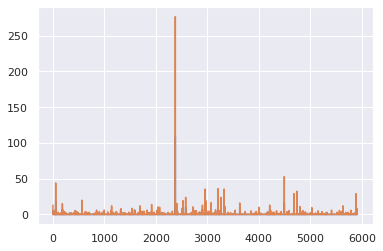

In [100]:
plt.plot(np.nanmedian(A_RNA, axis=1))
plt.plot(np.nanmedian(D_RNA, axis=1))

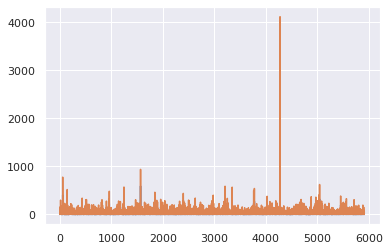

In [101]:
plt.plot(np.nanmedian(A_DNA, axis=1))
plt.plot(np.nanmedian(D_DNA, axis=1))

In [230]:
%%time
from classification.xclone_model.xclone_distrib import XCloneDistrib
from classification.xclone_model.xclone_gibbs_sampler import XCloneGibbsSampler
from classification.xclone_model.xclone_engine import XCloneEngine
import classification.xclone_model.xclone_routines as xclone_routines

datadict = {
    "D_DNA" : D_DNA,
    "D_RNA" : D_RNA,
    
    "A_DNA" : A_DNA,
    "A_RNA" : A_RNA,
    
    "I_DNA" : I_DNA,
    "CNV_DNA" : CNV_DNA,
    "T_max" : T_max
}
params = XCloneDistrib(datadict)
sampler = XCloneGibbsSampler()

xclone = XCloneEngine(
    workspace_dict=workspace,
    params=params,
    sampler=sampler,
    report_dir="/icgc/dkfzlsdf/analysis/B260/users/v390v/"\
                "xclone/data/tmp/xclone/STP_G&T/"\
                "05_11_2019/evening_run/real_data/DNA_vs_DNA",
    verbose=True
)
xclone

CPU times: user 2.82 s, sys: 1.21 s, total: 4.03 s
Wall time: 1.56 s


XCloneEngine, 2019-2020, Stegle Lab
Report dir: /icgc/dkfzlsdf/analysis/B260/users/v390v/xclone/data/tmp/xclone/STP_G&T/05_11_2019/evening_run/real_data/DNA_vs_DNA
This instance was created on 06/11/2019 01:25:57
DNA sample: STP_G&T
Cells in DNA sample: 80
RNA sample: STP_G&T
Cells in RNA sample: 80
Total number of CNV-haploblocks: 5912
Number of clones: 8
0 fitting iterations already passed
Sampler used: <class 'classification.xclone_model.xclone_gibbs_sampler.XCloneGibbsSampler'>
Initial total loglikelihood: -3264503.832637305
Current best total loglikelihood: -1411893.9702317805

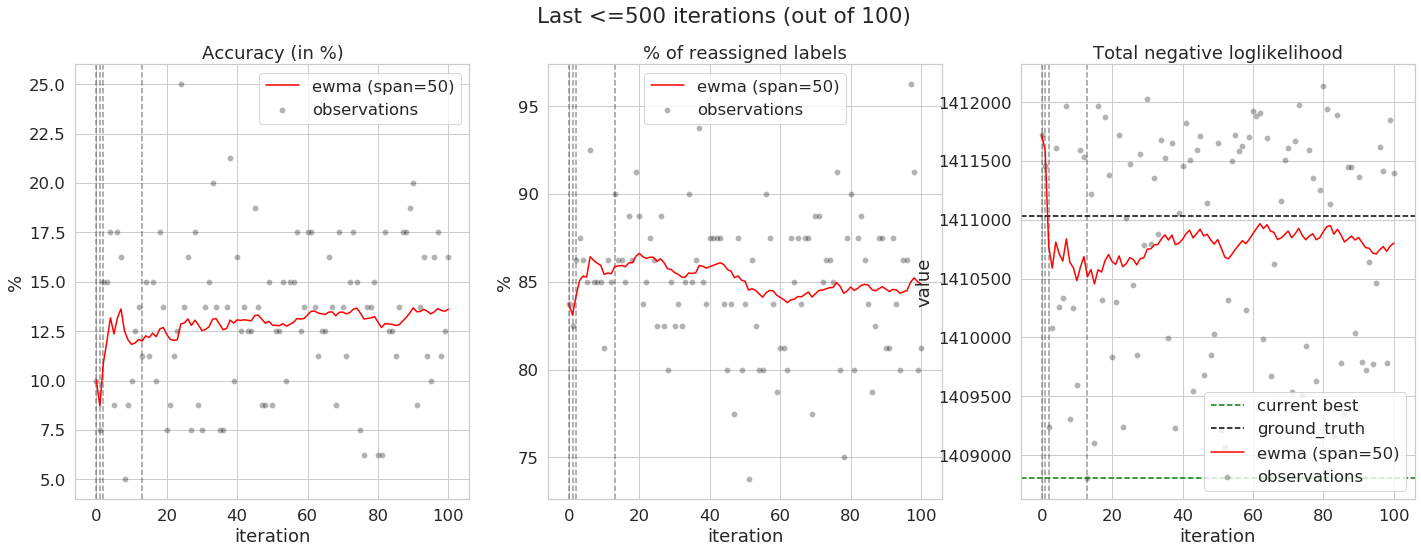

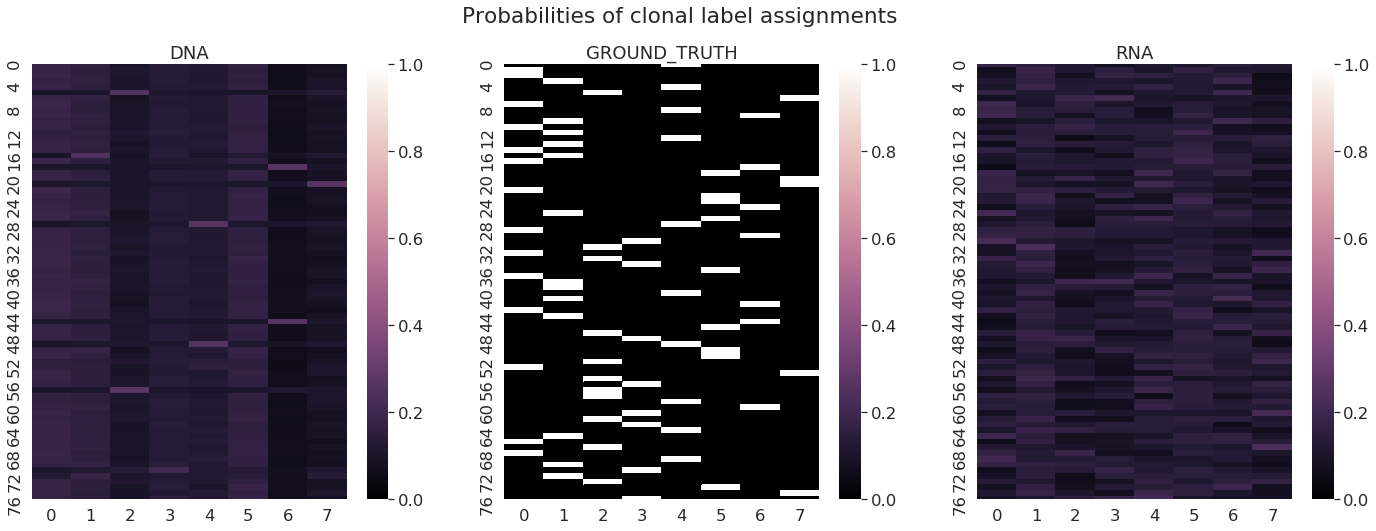

[-1229525.69296387  -179284.02184306]


In [ ]:
%%time
%matplotlib inline

from classification.xclone_model.xclone_diagnostics import gt_callback, GTConvergenceTracker
sns.set(font_scale=1.5, style="whitegrid")

xclone.fit(10000, gt_callback, GTConvergenceTracker())